In [ ]:
!pip install -U pygeos

In [ ]:
try:
  import rtree
except ModuleNotFoundError as e:
  !apt-get install libspatialindex-dev
  !pip install rtree
  import rtree

In [ ]:
!pip install contextily

In [ ]:
!pip install geopandas

In [ ]:
!pip install git+https://github.com/HTenkanen/pyrosm.git@master

In [ ]:
!pip install osmnx==0.16.2

In [ ]:
!pip install matplotlib==3.2.2

In [ ]:
!pip install mapclassify

In [ ]:
!pip install owslib

In [ ]:
!pip install pyshp

In [ ]:
!pip install bmi-arcgis-restapi

In [ ]:
!pip install -U plotly

# AirBnB Bologna - a geospatial analysis
The following notebook will analyse geospatial data from AirBnB referred to the City of Bologna, Italy, trying to answer to the questions reported at the beginning of each paragraph. 

The scope of the analysis is to illustrate different tools that can be used when dealing with this type of data.

The notebook comes with a Requirements.txt file that contains the libraries to be used to run this notebook, but for a matter of convenience there are also commented cells to install the packages directly from the notebook. In case the packages are installed directly from the notebook, please restart the runtime before running the cells, to ensure the correct version of the libraries are loaded. 

All the data used for the analysis can be fount in the "Data" folder but external links to the sources where they have been downloaded at are provided below.

## Data 
The main data files I will be using for the analysis are both provided by AirBnB, additional data comes from the municipality of Bologna.   


- listings data: http://data.insideairbnb.com/italy/emilia-romagna/bologna/2020-12-21/visualisations/listings.csv

- neighbourhoods data: http://data.insideairbnb.com/italy/emilia-romagna/bologna/2020-12-21/visualisations/neighbourhoods.geojson

- OSM information retrived via query at: https://export.hotosm.org/en/v3/exports/ce8032b1-92bd-44d8-a960-db9391a882b3

- statitical information regarding population of the city: http://inumeridibolognametropolitana.it/dati-statistici/popolazione-residente-eta-quartiere-e-zona-al-31-dicembre


### Data required to run this notebook: 
- Bologna_tourism.osm.pbf
- listings.csv
- pop_residente.csv 
- neighbourhoods.geojson




## Known limitations 
In case one wants to run the whole notebook so that slower computations are compiled while reading, I suggest to have a look at cell 37, which sometimes fails and neeeds to be run twice. 


In [ ]:
import geopandas as gpd
import pandas as pd 

/usr/local/lib/python3.7/dist-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [ ]:
listings = pd.read_csv("data/listings.csv") 
listings.head(3) 

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,42196,50 sm Studio in the historic centre,184487,Carlo,NaN,Santo Stefano,44.48507,11.34786,Entire home/apt,68,3,174,2020-01-03,1.41,3,162
1,46352,A room in Pasolini's house,467810,Eleonora,NaN,Porto - Saragozza,44.49168,11.33514,Private room,29,1,261,2020-11-02,2.12,3,365
2,59697,BOLOGNA CENTRE RELAX & COMFORT,286688,Paolo,NaN,Santo Stefano,44.48817,11.34124,Entire home/apt,70,1,240,2020-10-04,2.48,1,362


The cell above imports the dataframe containing records of rooms, apartments, hotel rooms and shared rooms available on the AirBnB platform in Bologna. As it can be seen above, it contains interesting information regarding the various units and, most interestingly for this analysis, their location encoded as latitude and longitude. The dataframe can be therefore transformed into a GeoDataFrame using Geopandas. 

In [ ]:
listings_geo = gpd.GeoDataFrame(
    listings,                       #pass the data
    crs='EPSG:4326',                #specify the system of coordinates 
    geometry=gpd.points_from_xy(listings.longitude, listings.latitude))   #and instruct geopandas regarding in which columns it can find the spatial coordinates of the units

The file containing the Multipolygons associated with the different neighbourhoods can also be read via Geopandas.


It can be seen that the city is divided into 6 different neighbourhoods. 

In [ ]:
neighbourhoods = gpd.read_file("data/neighbourhoods.geojson", driver="GeoJson")
neighbourhoods

,neighbourhood,neighbourhood_group,geometry
0,Borgo Panigale - Reno,None,"MULTIPOLYGON (((11.25132 44.55571, 11.25275 44..."
1,Navile,None,"MULTIPOLYGON (((11.37063 44.55166, 11.37067 44..."
2,Porto - Saragozza,None,"MULTIPOLYGON (((11.31848 44.51106, 11.31870 44..."
3,San Donato - San Vitale,None,"MULTIPOLYGON (((11.39932 44.54174, 11.39876 44..."
4,Santo Stefano,None,"MULTIPOLYGON (((11.35710 44.49376, 11.35730 44..."
5,Savena,None,"MULTIPOLYGON (((11.39101 44.48909, 11.39115 44..."


Using a unary union between these six geometries, the boundary shape of the whole city can be obtained and useed to retrieve the coordinates of Bologna bounds.

In [ ]:
from shapely.geometry import Polygon

In [ ]:
bologna_boundary = neighbourhoods.unary_union
bounds = bologna_boundary.bounds
bounds

(11.229662, 44.421103, 11.433724, 44.556202)

Encoding these bounds into a Shapely Polygon will create a bounding box that can be used for different purposes. 

(It has also been passed to HOT Export tool to generate the file containing OSM features)

In [ ]:
minx = bounds[0]
miny = bounds[1]
maxx = bounds[2]
maxy = bounds[3]

bbox = Polygon([[minx, miny], [maxx, miny], [maxx, maxy], [minx,maxy]])

## 1 - View statistical information on neighborhoods

The first requirement is to retrieve additional data regarding the neighbourhoods. Statatistical data available at Bologna city portal has already been mentioned, but let's check if interesting information can be fount using the Catalogue Web Services. 

In [ ]:
from owslib.csw import CatalogueServiceWeb
from requests import Request

After importing the required library, it can be performed a query to retrieve information from the Geoportal of Ministero dell'Ambiente.

In [ ]:
csw = CatalogueServiceWeb("http://www.pcn.minambiente.it/geoportal/csw")

In [ ]:
from owslib.fes import PropertyIsLike, BBox

The bounding box is converted to the format required by Catalogue Web Service.

In [ ]:
query_bbox = BBox(list(bounds))

And the query is filtered with this bounding box.

In [ ]:
csw.getrecords2(constraints=[query_bbox],maxrecords=120)

In [ ]:
csw.results

{'matches': 120, 'nextrecord': 0, 'returned': 120}

Titles and name of records are printed below. 

In [ ]:
for rec in csw.records:
  print(rec + " - " + csw.records[rec].title)

m_amte:299FN3:cd33e27d-3345-4de9-f321-9964934cc427 - DSM LAST LiDAR con risoluzione a terra 1 metro - Regione Emilia Romagna
m_amte:299FN3:eb634e29-bfb0-46ef-cd46-95cbe7be1c76 - DTM LiDAR con risoluzione a terra 1 metro - Regione Emilia Romagna
m_amte:299FN3:d3c0c99b-c6a5-4750-f1cb-bbe8b4698f57 - DSM FIRST LiDAR con risoluzione a terra 1 metro - Regione Emilia Romagna
m_amte:299FN3:8d33a96b-91e3-41c1-84bb-d63a3b3909ea - INTENSITY LiDAR con risoluzione a terra 1 metro - Regione Emilia Romagna
m_amte:299FN3:e9d6d68e-0fbf-4d6f-8166-cd2c3a25fb4d - Prodotti LiDAR - Regione Emilia Romagna
m_amte:299FN3:5919f8f2-34fe-4625-be41-9aa0eddac6a3 - Quadro di unione COSMO SKY-MED Ascending - PST 2009
m_amte:299FN3:9b0c55fc-6c4d-4e76-c158-7664b42f2565 - Quadro di unione COSMO SKY-MED Descending - PST 2009
m_amte:299FN3:5eddcaa5-915f-4eec-b00e-f018a60510c0 - Santuario per i mammiferi marini
m_amte:299FN3:4dca3621-4baa-49ee-90b5-33ca42a4bb4e - Ortofoto in bianco e nero anni 1994-1996 - Regioni zona WGS8

There is a lot of data referred to geological characteristics and few information regarding the neighbourhoods and their statistical information. As an example, the record containing information regarding italian schools will be downloaded. 

In [ ]:
schools = "m_amte:299FN3:8345a338-17c9-444b-c598-fe508d1cb45e"
record_schools = csw.records[schools]

The cell below retrieves the url where the record is contained.

In [ ]:
for reference in record_schools.references:
  print(reference['scheme'])
  print(reference['url'])

urn:x-esri:specification:ServiceType:ArcIMS:Metadata:Server
http://www.pcn.minambiente.it/viewer/index.php?services=scuole_statali_paritarie
urn:x-esri:specification:ServiceType:ArcIMS:Metadata:Server
http://wms.pcn.minambiente.it/ogc?map=/ms_ogc/wfs/Scuole_statali_paritarie.map&Service=WFS
urn:x-esri:specification:ServiceType:ArcIMS:Metadata:Server
http://wms.pcn.minambiente.it/ogc?map=/ms_ogc/WMS_v1.3/Vettoriali/Scuole_statali_paritarie.map
urn:x-esri:specification:ServiceType:ArcIMS:Metadata:Thumbnail
http://www.pcn.minambiente.it/anteprima/scuole_statali_paritarie.gif
urn:x-esri:specification:ServiceType:ArcIMS:Metadata:Document
http://www.pcn.minambiente.it/geoportal/csw?getxml=%7BD3D1C3D8-F2C8-4D7C-A796-C3F1EA45E063%7D
OGC:WMS
http://wms.pcn.minambiente.it/ogc?map=/ms_ogc/WMS_v1.3/Vettoriali/Scuole_statali_paritarie.map
OGC:WFS
http://wms.pcn.minambiente.it/ogc?map=/ms_ogc/wfs/Scuole_statali_paritarie.map&Service=WFS


In [ ]:
from owslib.wfs import WebFeatureService

In [ ]:
url_scuole = "http://wms.pcn.minambiente.it/ogc?map=/ms_ogc/wfs/Scuole_statali_paritarie.map&Service=WFS"

In [ ]:
wfs_scuole = WebFeatureService(url=url_scuole,version="1.1.0")

And Web Feature Service is used to actually download the data contained in the record and to read its description.

In [ ]:
for layer, meta in wfs_scuole.items():
    print(meta.__dict__)
    print(meta.title)
    print(meta.abstract)
    print(meta.crsOptions)
    print(meta.outputFormats)

{'auth': <Authentication shared=False username=None password=None cert=None verify=True auth_delegate=None>, 'headers': None, 'id': 'SPU.SCUOLE.', 'title': "Scuole pubbliche per l'infanzia, primarie e secondarie sul territorio nazionale", 'abstract': "Localizzazione degli istituti scolastici pubblici per l'infanzia, primarie e secondarie in base agli indirizzi forniti dal Mistero dell'Istruzione, dell'UniversitÃ\xa0 e della Ricerca. La tabella associata contiene le seguenti informazioni: COD_MECCANOGRAFICO, codice meccanografico univoco per ogni singolo istituto scolastico; DENOMINAZIONE, denominazione dell'istituto scolastico; TIPO_SCUOLA, tipologia di istituto scolastico; INDIRIZZO, dell'istituto scolastico risolto per mezzo dell'operazione di geocoding; COMUNE, comune di appartenenza dell'istituto scolastico; CAP, codice di avviamento postale della localitÃ\xa0 di appartenenza dell'istituto scolastico; TELEFONO, numero di telefono dell'istituto scolastico; EMAIL, indirizzo di posta 

In [ ]:
layer_scuole = list(wfs_scuole.contents)[0]

In [ ]:
response_scuole = wfs_scuole.getfeature(typename=layer_scuole, bbox=bounds,srsname='urn:ogc:def:crs:EPSG::4326')

The response is written to a shape file.

In [ ]:
out = open('data/scuole.xml', 'wb')
out.write(response_scuole.read())
out.close()

And read with GeoPandas. 
Below it can be noticed that the geometry has been encoded with inverted longitude and latitude

In [ ]:
scuole = gpd.read_file("data/scuole.xml")
scuole.head(3)  

,gml_id,cod_meccanografico,denominazione,tipo_scuola,indirizzo,comune,cap,telefono,fax,email,sito_web,cod_istituto_principale,statale,pec,geometry
0,SPU.SCUOLE..8457,BOEE818012,LIVIO TEMPESTA,SCUOLA PRIMARIA,VIA MARTELLI 37,BOLOGNA,40138.0,051531294,051531294,BOIC81800X@istruzione.it,www.ic7bologna.it,BOIC81800X,STATALE,None,POINT (44.49072 11.39911)
1,SPU.SCUOLE..7930,BO1A01700E,SANTA RITA,SCUOLA DELL'INFANZIA,"VIA SANTA RITA, 6",BOLOGNA,40138.0,051 6010017,051 6010017,asilos.rita@libero.it,None,BO1A01700E,PARITARIA,None,POINT (44.49530 11.38471)
2,SPU.SCUOLE..7950,BO1A042007,SCUOLA DELL'INFANZIA SAN SEVERINO,SCUOLA DELL'INFANZIA,"VIA DAGNINI, 23/2",BOLOGNA,40137.0,051444647,051444950,SCUINFSEVERINO@LIBERO.IT,info@scuolasanseverino.it,BO1A042007,PARITARIA,None,POINT (44.47870 11.36890)


The problem is fixed unpacking the geometry column into two different columns and then creating the GeoDataFrame again. 

In [ ]:
scuole["latitude"] = scuole.geometry.x
scuole["longitude"] = scuole.geometry.y
scuole.drop(columns=["geometry"])
scuole_geo = gpd.GeoDataFrame(scuole, crs='EPSG:4326',geometry=gpd.points_from_xy(scuole.longitude, scuole.latitude))
scuole_geo.head(3) 

,gml_id,cod_meccanografico,denominazione,tipo_scuola,indirizzo,comune,cap,telefono,fax,email,sito_web,cod_istituto_principale,statale,pec,geometry,latitude,longitude
0,SPU.SCUOLE..8457,BOEE818012,LIVIO TEMPESTA,SCUOLA PRIMARIA,VIA MARTELLI 37,BOLOGNA,40138.0,051531294,051531294,BOIC81800X@istruzione.it,www.ic7bologna.it,BOIC81800X,STATALE,None,POINT (11.39911 44.49072),44.490723,11.399109
1,SPU.SCUOLE..7930,BO1A01700E,SANTA RITA,SCUOLA DELL'INFANZIA,"VIA SANTA RITA, 6",BOLOGNA,40138.0,051 6010017,051 6010017,asilos.rita@libero.it,None,BO1A01700E,PARITARIA,None,POINT (11.38471 44.49530),44.495300,11.384705
2,SPU.SCUOLE..7950,BO1A042007,SCUOLA DELL'INFANZIA SAN SEVERINO,SCUOLA DELL'INFANZIA,"VIA DAGNINI, 23/2",BOLOGNA,40137.0,051444647,051444950,SCUINFSEVERINO@LIBERO.IT,info@scuolasanseverino.it,BO1A042007,PARITARIA,None,POINT (11.36890 44.47870),44.478699,11.368896


Then a spatial join is performed to check which schools belong to which neighbourhoods. This operation can be performed using the file containing the geometries of the neighbours and asking GeoPandas to match which schools fall in the Polygon of each neighbours. 
Before running the operation one should always check that the two different GeoDataFrame are encoded in the same system of coordinates. This can be done looking at the .crs of the two sources. 

In [ ]:
print(" ",scuole_geo.crs, "\n ", neighbourhoods.crs)

  EPSG:4326 
  epsg:4326


Below data has been grouped to easily detect the count of different schoools among the different spatial units of the city.

In [ ]:
scuole_neigh = gpd.sjoin(neighbourhoods, 
                          scuole_geo, how='inner', predicate='contains', lsuffix='neigh_', rsuffix='schools_').reset_index()

scuole_x_neigh = scuole_neigh.groupby(["neighbourhood", "tipo_scuola"]).size().to_frame("N.Schools").reset_index()
scuole_x_neigh_simple = scuole_neigh.groupby(["neighbourhood"]).size().to_frame("N.Schools").reset_index()
scuole_x_neigh

,neighbourhood,tipo_scuola,N.Schools
0,Borgo Panigale - Reno,SCUOLA DELL'INFANZIA,20
1,Borgo Panigale - Reno,SCUOLA PRIMARIA,15
2,Borgo Panigale - Reno,SCUOLA SECONDARIA DI PRIMO GRADO,3
3,Borgo Panigale - Reno,SCUOLA SECONDARIA DI SECONDO GRADO,6
4,Navile,SCUOLA DELL'INFANZIA,23
5,Navile,SCUOLA PRIMARIA,12
6,Navile,SCUOLA SECONDARIA DI PRIMO GRADO,7
7,Navile,SCUOLA SECONDARIA DI SECONDO GRADO,23
8,Porto - Saragozza,SCUOLA DELL'INFANZIA,23
9,Porto - Saragozza,SCUOLA PRIMARIA,15


We will try to find additional data provided by ArcGis. This data is from the Italian Civil Protection department, so we don't expect to find a lot of information that is relevant for this analysis. 

In [ ]:
import os
os.environ['RESTAPI_USE_ARCPY'] = 'FALSE'
import restapi

In [ ]:
rest_url = 'https://services6.arcgis.com/L1SotImj1AAZY1eK/ArcGIS/rest/services'
ags = restapi.ArcServer(rest_url)

In [ ]:
ags.services

[{
  "name": "campi_scuola_2018",
  "type": "FeatureServer",
  "url": "https://services6.arcgis.com/L1SotImj1AAZY1eK/ArcGIS/rest/services/campi_scuola_2018/FeatureServer"
},
 {
  "name": "CampiScuola_2019",
  "type": "FeatureServer",
  "url": "https://services6.arcgis.com/L1SotImj1AAZY1eK/ArcGIS/rest/services/CampiScuola_2019/FeatureServer"
},
 {
  "name": "campiscuola2018_def",
  "type": "FeatureServer",
  "url": "https://services6.arcgis.com/L1SotImj1AAZY1eK/ArcGIS/rest/services/campiscuola2018_def/FeatureServer"
},
 {
  "name": "CapoluoghiProvincia",
  "type": "FeatureServer",
  "url": "https://services6.arcgis.com/L1SotImj1AAZY1eK/ArcGIS/rest/services/CapoluoghiProvincia/FeatureServer"
},
 {
  "name": "Comuni_Terremotati",
  "type": "FeatureServer",
  "url": "https://services6.arcgis.com/L1SotImj1AAZY1eK/ArcGIS/rest/services/Comuni_Terremotati/FeatureServer"
},
 {
  "name": "Comuni_terremoto",
  "type": "FeatureServer",
  "url": "https://services6.arcgis.com/L1SotImj1AAZY1eK/ArcGIS

As expected, there is a lot of information regarding eartquakes and institutional projects to handle catastrophes, but there is also a record on "Capoluoghi di Provincia".

In [ ]:
ags_service = ags.getService('CapoluoghiProvincia') #I have to admit this cells sometimes fails, throwing an error. I know it might seem to be unprofessional, but running the cell again solves the problem.
ags_service.list_layers() 

['CapoluoghiProvincia']

The record layer is exported specifying the system of coordinates it has to be encoded in.

In [ ]:
capoluoghi = ags_service.layer('CapoluoghiProvincia')

In [ ]:
capoluoghi.export_layer('data/capoluoghi.shp', outSR=4326) 

Created: "capoluoghi.shp"


'capoluoghi.shp'

And again, the shapefile is imporrted  into GeoPandas.

In [ ]:
capoluoghi_gpd = gpd.read_file('data/capoluoghi.shp')

Filter the dataset to have just the record referred to the city of our interest. 

In [ ]:
bologna_cws = capoluoghi_gpd[capoluoghi_gpd.within(bologna_boundary)]
bologna_cws

,COD_ISTAT,COD_REG,COD_PRO,PRO_COM,LOC2011,LOC,TIPO_LOC,DENOMINAZI,ALTITUDINE,CENTRO_CL,POPRES,MASCHI,FAMIGLIE,ABITAZIONI,EDIFICI,FID_1,COD_RIP,COD_REG_1,COD_PROV,COD_CM,COD_PCM,DEN_PROV,DEN_CM,DEN_PCM,SIGLA,ORIG_FID,geometry
39,8037006.0,8.0,37.0,37006.0,3.700610e+09,10002.0,1.0,Bologna,54,1.0,366133.0,169786.0,191119.0,204265.0,28169.0,36.0,2.0,8.0,37.0,237.0,237.0,-,Bologna,Bologna,BO,39.0,POINT (11.342 44.494)


And save the value associated to the number of city inhabitants into a variable. 

In [ ]:
pop_res_cws = int(bologna_cws.POPRES.values[0])

Now the file regarding population downloaded from the city portal is imported. It contains info regarding population in each neighbourhood and zones divided into age classes. Below there is a sneak peek of the content.

In [ ]:
pop = pd.read_csv("data/pop_residente.csv", sep=";")
pop.head(6)

The column associated to the neighbourhood name is translated to have it encoded as in the other dataframes to have it easily mergable. 

In [ ]:
pop.columns = pop.columns.str.replace("Quartiere", "neighbourhood")

A simplfied file which doesn't consider zones and age classes and excludes records regarding homeless people is created.  


In [ ]:
pop_simple = pop.groupby("neighbourhood").sum().reset_index()
pop_simple = pop_simple[pop_simple.neighbourhood != 'Senza fissa dimora']
pop_simple.head(10)

,neighbourhood,Residenti
0,Borgo Panigale - Reno,61359
1,Navile,69525
2,Porto - Saragozza,69595
3,San Donato - San Vitale,66320
4,Santo Stefano,64510
5,Savena,60142


And used to perform a join to have the geometry column and  calculate the population density per neighbourhoood. 

First of all the coordinates needs to be converted into a system that takes into account geometries in meters, then  the area of each neighbourhood, expressed in squared meters, is transformed into squared kilometers and finally the density, defined as number of inhabitants per square kilometer is computed. 

The computation should be correct, as measure obtained with the same calculus to the whole city (2775.84 people per km2) is close to the result fount on the web. 

https://www.tuttitalia.it/emilia-romagna/32-bologna/

In [ ]:
pop_simple_neigh = pop_simple.set_index("neighbourhood").join(neighbourhoods.set_index('neighbourhood')).reset_index()
pop_simple_geo = gpd.GeoDataFrame(pop_simple_neigh, crs="epsg:4326", geometry=pop_simple_neigh.geometry)
pop_simple_geo["Pop_density"] = round(pop_simple_geo.Residenti / (pop_simple_geo.to_crs('epsg:32633').area/ 10**6),2)

pop_simple_geo

,neighbourhood,Residenti,neighbourhood_group,geometry,Pop_density
0,Borgo Panigale - Reno,61359,None,"MULTIPOLYGON (((11.25132 44.55571, 11.25275 44...",1949.26
1,Navile,69525,None,"MULTIPOLYGON (((11.37063 44.55166, 11.37067 44...",2683.66
2,Porto - Saragozza,69595,None,"MULTIPOLYGON (((11.31848 44.51106, 11.31870 44...",4408.47
3,San Donato - San Vitale,66320,None,"MULTIPOLYGON (((11.39932 44.54174, 11.39876 44...",2521.85
4,Santo Stefano,64510,None,"MULTIPOLYGON (((11.35710 44.49376, 11.35730 44...",2144.79
5,Savena,60142,None,"MULTIPOLYGON (((11.39101 44.48909, 11.39115 44...",5241.85


Below the population density is visualized with a Choroplet map in MatPlotLib.

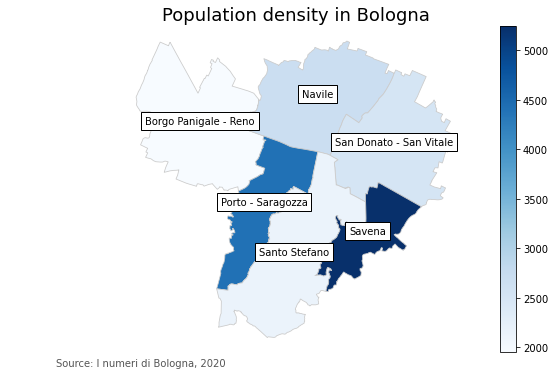

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(1, figsize=(10, 6))
vmin, vmax = 1949.26, 5241.85

pop_simple_geo.plot(column="Pop_density", cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8')

ax.axis('off')
ax.set_title('Population density in Bologna', fontdict={'fontsize': "18", 'fontweight' : '3'})
#create annotation for neighbourhood name

for name, geo in zip(pop_simple_geo.neighbourhood, pop_simple_geo.geometry): 
  plt.text(geo.centroid.x, geo.centroid.y, name, horizontalalignment='center',bbox=dict(facecolor='white')) 

# create an annotation for the data source
ax.annotate("Source: I numeri di Bologna, 2020", xy=(0.1, .08),  xycoords='figure fraction', horizontalalignment='left', verticalalignment='top', fontsize=10, color='#555555')

sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=vmin, vmax=vmax))
# empty array for the data range
sm._A = []
# add the colorbar to the figure
cbar = fig.colorbar(sm)
fig.show()

Just as a comparison, we can look at the data obtained from Catalogue Web Service (which we saved into a variable) and the one obtained via the Bologna city portal to check if there are differences.

In [ ]:
print("Bologna city portal:",pop_simple_geo.Residenti.sum(),"\nCatalogue Web Service:", pop_res_cws)

Bologna city portal: 391451 
Catalogue Web Service: 366133


It seems like the Catalogue Web Service contains a different record. The one obtained from the city portal should be more reliable. 

## 2 - Identify which are the neighborhoods with the highest prices in AirBnB

Below there is a Choroplet map representing the mean prices of AirBnb listings in the different city's neighbourhoods.

In [ ]:
import json
with open('data/neighbourhoods.geojson') as response:
  neighbourhoods_map = json.load(response)

In [ ]:
import plotly.express as px
import plotly.graph_objects as go
from shapely.geometry import Point

  
point = gpd.tools.geocode("Piazza Re Enzo, Bologna", provider="arcgis")   
bologna_point = Point((point.geometry.x.values[0], point.geometry.y.values[0]))

fig = px.choropleth_mapbox( listings, geojson=neighbourhoods_map,
                    featureidkey='properties.neighbourhood',
                    locations="neighbourhood", 
                    color='price',
                    color_continuous_scale='Reds', 
                    range_color=(0,100), labels="neighbourhood", 
                    opacity=.4)
                          

fig.update_geos(fitbounds="locations", visible=False)

fig.update_layout(title="Chroplet map for AirBnb prices in Bologna by neighbourhood",mapbox_style="carto-positron",
                  mapbox_zoom=10.5, mapbox_center = {"lat": bologna_point.y, "lon": bologna_point.x})

fig.update_layout(margin={"r":0,"t":40,"l":0,"b":0})
fig.show()

First of all, I want to have an idea of the most expensive listings in the city.
Below there is a sneak peek of the 15 most expensive apartments, it can be noticed the difference in price between the first and the second listing is very high (1000€ per night), therefore it seems reasonable to refer to the median price per neighbourhood rather than the mean one, as this measure could be biased by the prices distribution.   

In [ ]:
listings_geo.sort_values(by="price", ascending=False).head(15)[["name", "price", "neighbourhood", "room_type", "geometry"]].reset_index().drop(columns="index")

,name,price,neighbourhood,room_type,geometry
0,A quiet Place to stay,3000,Porto - Saragozza,Entire home/apt,POINT (11.33956 44.49824)
1,Luxury Attic Jacuzzi a sfioro Vasca Ovale & Ca...,2000,Porto - Saragozza,Entire home/apt,POINT (11.34058 44.49907)
2,Giardini Margherita apartments - Flat in Italy,2000,Santo Stefano,Entire home/apt,POINT (11.34745 44.48462)
3,Bolognina Apartments - Flat in Italy,2000,Navile,Entire home/apt,POINT (11.34129 44.50918)
4,Flatinbo Apartments - Apollo,2000,Navile,Entire home/apt,POINT (11.33074 44.50957)
5,FlatinBo Apartaments via De' Carracci- Zues,2000,Navile,Hotel room,POINT (11.33039 44.50797)
6,Flatinbo Apartments - Galliera,2000,Porto - Saragozza,Private room,POINT (11.34244 44.49956)
7,Angy Vi. Apartments - Flat in Bo,2000,Porto - Saragozza,Entire home/apt,POINT (11.33906 44.49765)
8,Lusso Moderno ZonaOspedale Sant’Orsola Univer...,1600,San Donato - San Vitale,Entire home/apt,POINT (11.35777 44.49667)
9,Falegnami Suites - Entire Palace!,1526,Porto - Saragozza,Entire home/apt,POINT (11.34271 44.49901)


I also would like to have a look at the prices in the area around the most expensive listing, to have a quick idea if it is the position to determine the price or if there are other features that one should look at. 

First of all, An area of 100 mq around the listing "A quiet Place to stay" is computed (transforming the coordinates to a system which takes into account the distances in meters), then I identify the other listings contained in that area and look at the prices with a spatial join. 

In [ ]:
target_area = listings_geo[listings_geo.name=="A quiet Place to stay"]
target_area["geometry"] = target_area.to_crs(epsg=32632).buffer(100)

result = gpd.sjoin(target_area.to_crs(epsg=32632), listings_geo.to_crs(epsg=32632), how='inner', predicate='contains', lsuffix='target', rsuffix='hosts').reset_index()[["name_hosts",	"neighbourhood_hosts",	"room_type_hosts",	"price_hosts"]]

result.sort_values(by="price_hosts").reset_index().drop(columns="index")

/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,name_hosts,neighbourhood_hosts,room_type_hosts,price_hosts
0,b&b galleria del reno,Porto - Saragozza,Private room,30
1,lovely flat in Bologna city center,Porto - Saragozza,Entire home/apt,38
2,Downtown Loft,Porto - Saragozza,Entire home/apt,43
3,"Eco Chic room, private bathroom UV Air Purifier",Porto - Saragozza,Private room,45
4,Elegance Luxury Studio - HEPA UV Air Purifier,Porto - Saragozza,Entire home/apt,47
5,Red Racing Motor Valley Loft - UV Air purifier,Porto - Saragozza,Entire home/apt,48
6,Cozy apartment in the center if Bologna,Porto - Saragozza,Entire home/apt,50
7,Luxury Extreme - HEPA UV Germicidal Air Purifer,Porto - Saragozza,Entire home/apt,52
8,Elegance Studio UV Germicidal Purifer with TER...,Porto - Saragozza,Entire home/apt,53
9,"Luxury Attic UV air purifier, TERRACE - Tower ...",Porto - Saragozza,Entire home/apt,54


In the area around the most expensive listing in Bologna we have 40 other listings, with variegated prices. We also see in this list there is one of the listings with the second highest price in the whole city (Angy Vi. Apartments - Flat in Bo). From this preliminar analysis it can be concluded that the price of that particular apartment probably depends on other features (such as the luxury in the fornitures) rather than its position, as in a radius of 100 meters listings which costs 30€ per night are found as well. It can also be noticed that the very same price (or very similar prices) is associated to different room types, so there as to be some other parameters that concurr in price definition.

In [ ]:
mean = round(listings_geo.groupby("neighbourhood").mean(),2)["price"].to_frame("Mean_Price").reset_index()
median = listings_geo.groupby("neighbourhood").median()["price"].to_frame("Median_Price").reset_index()
neigh_prices = pd.merge(mean, median, on = "neighbourhood")

neigh_prices.sort_values(by="Median_Price", ascending=False).reset_index().drop(columns="index")

,neighbourhood,Mean_Price,Median_Price
0,Santo Stefano,97.84,69.0
1,Porto - Saragozza,103.80,65.0
2,San Donato - San Vitale,90.11,55.5
3,Navile,93.58,54.0
4,Savena,78.13,50.0
5,Borgo Panigale - Reno,71.05,49.0


The neighbourhood with the most expensive listings is Porto-Saragozza but the one with highest median prices is Santo Stefano.

Below a scatter distribution of the prices coloured on the basis of the observed percentiles. 

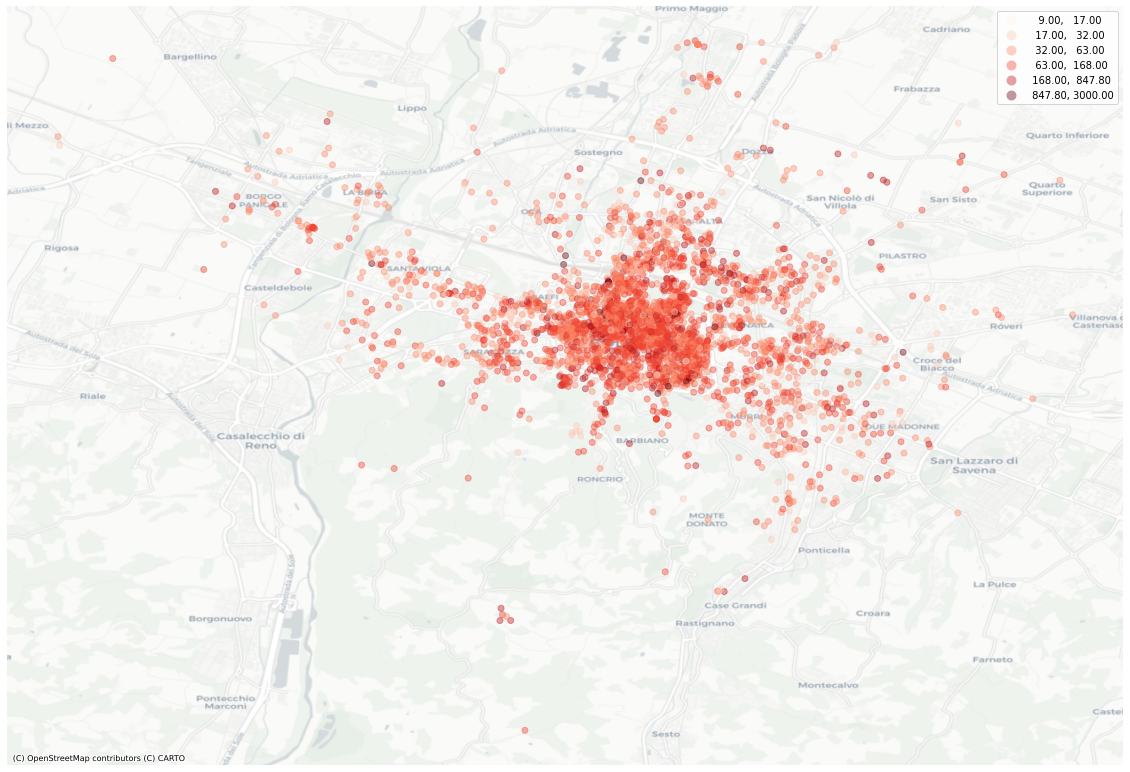

In [ ]:
import contextily as cx 
%matplotlib inline 
fig, ax = plt.subplots(1, figsize=(20, 15))



listings_geo.to_crs(epsg=4326).plot(column="price",    #instruct plt to focus on price column
                    alpha=.4, edgecolor=None,          #set the point to be transparent so that the density is visually detectable
                    cmap="Reds", legend=True,           #color map and legend
                    scheme="percentiles", ax=ax)      #which measure to use and which axes to add the plot to

ax.axis("off")      #turn of axis 


cx.add_basemap(ax,crs=listings_geo.to_crs(epsg=4326).crs.to_string(),  #add basemap with correct crs 
               source=cx.providers.CartoDB.Positron)


fig.show()

The map below plots all the available listings in the city of Bologna grouped by accomodation type.

In [ ]:
from shapely.geometry import Point

In [ ]:
point = gpd.tools.geocode("Piazza Re Enzo, Bologna", provider="arcgis")   
bologna_point = Point((point.geometry.x.values[0], point.geometry.y.values[0]))

In [ ]:
fig2 = px.scatter_mapbox(listings_geo,
                    lat=listings_geo.geometry.y,
                    lon=listings_geo.geometry.x,
                    hover_name="name", 
                    color="room_type", 
                    hover_data={'room_type':False,
                                'latitude':False, 
                                'longitude': False, 
                                'name':False}, 
                    color_discrete_sequence= px.colors.qualitative.T10)




fig2.update_geos(fitbounds="locations", visible=False)

fig2.update_layout(title="AirBnb accomodation type",mapbox_style="carto-positron", 
                  mapbox_zoom=10.5, mapbox_center = {"lat": bologna_point.y, "lon": bologna_point.x})
fig2.update_layout(margin={"r":0,"t":40,"l":0,"b":0})

## 3 - Identify which are the districts with the greatest number of tourist activities

Data for this part of the analysis comes from the file, containing Open Street Map features, obtained with the HOT export tool. 

First of all the file is converted into a valid Pyrosm object in order to correctly handle it.


In [ ]:
import pyrosm
from pyrosm import OSM
osm = pyrosm.OSM("data/Bologna_tourism.osm.pbf")

Thenthe dataframe  with information on touristic points of interest is constructed. 

First of all a filter to instruct Pyrosm on which features we are interested in is created, then a column with information on the type of point of interest is added and finally the results are cut, in order to just consider the points that fall inside the polygon of the city. 

In [ ]:
from pyrosm import get_data
import numpy as np
custom_filter = {'tourism': True, "hotel": True, "hostel":True, "gallery":True, "historic":True}
pois_tourism = osm.get_pois(custom_filter=custom_filter)
pois_tourism.set_crs(epsg=4326)
pois_tourism["poi_type"] = pois_tourism["tourism"]
pois_tourism.poi_type.fillna(value=np.nan, inplace=True)
pois_tourism.name.fillna(value="", inplace=True)
pois_tourism["poi_type"].fillna(pois_tourism["historic"], inplace= True)

pois_bologna_tourism = pois_tourism[pois_tourism.within(bologna_boundary)]
pois_bologna_tourism.tail(5)

,changeset,timestamp,tags,id,version,lat,lon,addr:city,addr:country,addr:housenumber,addr:housename,addr:postcode,addr:street,email,name,opening_hours,operator,phone,ref,website,information,tourism,historic,memorial,geometry,osm_type,building,poi_type
459,-1.0,1590324480,"{""amenity"":""place_of_worship"",""denomination"":""...",431041747,6,NaN,NaN,None,NaN,None,NaN,None,None,None,Chiesa di San Salvatore,None,None,None,NaN,None,NaN,None,church,NaN,"POLYGON ((11.33870 44.49381, 11.33875 44.49400...",relation,church,church
460,-30.0,1585409588,"{""source"":""Regione Emilia Romagna"",""start_date...",469186254,2,NaN,NaN,None,NaN,None,NaN,None,None,None,Palazzo Fantuzzi,None,None,None,NaN,None,NaN,None,yes,NaN,"POLYGON ((11.34987 44.49401, 11.34995 44.49433...",relation,yes,yes
461,58.0,1597413083,"{""source"":""Regione Emilia Romagna"",""type"":""mul...",619911734,2,NaN,NaN,None,NaN,None,NaN,None,None,None,,None,None,None,NaN,None,NaN,museum,None,NaN,"POLYGON ((11.35144 44.51334, 11.35188 44.51326...",relation,yes,museum
462,124.0,1599607276,"{""barrier"":""city_wall"",""type"":""multipolygon"",""...",2508930280,3,NaN,NaN,None,NaN,None,NaN,None,None,None,Porta Maggiore,None,None,None,NaN,None,NaN,None,city_gate,NaN,"MULTILINESTRING ((11.35725 44.49014, 11.35718 ...",relation,yes,city_gate
463,-19.0,1590324965,"{""amenity"":""place_of_worship"",""denomination"":""...",2612235970,3,NaN,NaN,None,NaN,None,NaN,None,None,None,Eremo di Ronzano,None,None,None,NaN,None,NaN,None,yes,NaN,"POLYGON ((11.32197 44.47426, 11.32182 44.47388...",relation,yes,yes


From the sneak peek above it can be noticed there are some units with nan for longitude and latitude, luckly this information can be retrieved from the geometry column.

In [ ]:
pois_bologna_tourism["lat"] = pois_bologna_tourism.lat.fillna(value=pois_bologna_tourism.to_crs(epsg=4326).geometry.centroid.y, inplace=True)
pois_bologna_tourism["lon"] = pois_bologna_tourism.lon.fillna(value=pois_bologna_tourism.to_crs(epsg=4326).geometry.centroid.x, inplace=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning:

Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.


/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4536: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning:

Geometry i

Then a spatial join to see how many touristic point of interest can be found in each neighbourhood is performed.

With this operation two points that are located on the bounds of the city get lost.

In [ ]:
pois_neigh_tourism = gpd.sjoin(neighbourhoods, 
                          pois_bologna_tourism, how='inner', predicate='contains', lsuffix='neigh_', rsuffix='pois_').reset_index()

In [ ]:
pois_x_neigh_tourism = pois_neigh_tourism.groupby(['neighbourhood']).size().to_frame('N.TouristicPois').reset_index()
pois_x_neigh_tourism.sort_values(by="N.TouristicPois", ascending=False).reset_index().drop(columns="index")

,neighbourhood,N.TouristicPois
0,Santo Stefano,154
1,Porto - Saragozza,100
2,Navile,51
3,San Donato - San Vitale,29
4,Borgo Panigale - Reno,22
5,Savena,13


The neighbourhood with the highest number of Touristic Points of interest is Santo Stefano. It seems that the count of this type of points concurr in the price definition more than the specific location of the listing.

The data downloaded from OSM contains a lot of point of interest of type "hotel", "hostel", "guest house", which are not interesting for a user that booked an house on AirBnb, below the results with points of this type excluded.


In [ ]:
pois_neigh_tourism2 = pois_neigh_tourism.drop(pois_neigh_tourism[pois_neigh_tourism.poi_type.isin(["hotel", "hostel", "guest_house"])].index)

pois_x_neigh_tourism2 = pois_neigh_tourism2.groupby(['neighbourhood']).size().to_frame('N.TouristicPois').reset_index()
pois_x_neigh_tourism2.sort_values(by="N.TouristicPois", ascending=False).reset_index().drop(columns="index")


,neighbourhood,N.TouristicPois
0,Santo Stefano,122
1,Porto - Saragozza,50
2,Navile,34
3,Borgo Panigale - Reno,15
4,San Donato - San Vitale,11
5,Savena,10


In [ ]:
pois_neigh_tourism.loc[pois_neigh_tourism.poi_type.isin(["hotel", "guest_house", "hostel", "apartment"]), "poi_type"] = "touristic accomodation"

In [ ]:
fig3 = px.scatter_mapbox(pois_neigh_tourism,
                    lat=pois_neigh_tourism.lat,
                    lon=pois_neigh_tourism.lon,
                    hover_name="name", 
                    color="poi_type", 
                    hover_data={'poi_type':True,
                                'name':False, },
                    color_discrete_sequence=px.colors.qualitative.Dark24)



fig3.update_geos(fitbounds="locations", visible=False)

fig3.update_layout(title="Turistic point of interests in Bologna",mapbox_style="carto-positron", 
                  mapbox_zoom=10.5, mapbox_center = {"lat": bologna_point.y, "lon": bologna_point.x})
fig3.update_layout(margin={"r":0,"t":40,"l":0,"b":0})

fig3.show()

## 4 -  Find the location of 3 AirBnB hosts closest to one of the city's museums (on walking distance). 

The museum we will focus on is the MAMbo museum, Museum of Modern Art in Bologna. 

http://www.mambo-bologna.org/

The geographical coordinates of the museum need to be saved into a varible. 


In [ ]:
point_mambo = (pois_bologna_tourism[pois_bologna_tourism.name=="MAMbo"].representative_point().y.values[0], pois_bologna_tourism[pois_bologna_tourism.name=="MAMbo"].representative_point().x.values[0])

Then the graph representing the city of Bologna as nodes and edges is build. 
Osmnx allows to do this from the string of the name of the city. 

In [ ]:
import osmnx as ox
G = ox.graph_from_place("Bologna, Italy", network_type='walk')

The the node in the graph that is most close to the actual position of the museum is identified with an osmnx function. 

In [ ]:
node_mambo = ox.get_nearest_node(G, point_mambo)

The graph is enriched with weighted edges for different velocities associated to different type of streets (the streets are in fact the edges of the graph).

In [ ]:
hwy_walking_speeds = {
    'motorway ': 0.5,
    'trunk': 0.5,
    'primary': 0.5,
    'secondary': 0.5,
    'tertiary': 0.5,
    'unclassified': 3.5,
    'residential': 3.5,
    'service': 3.5,
    'crossing': 3.5,
    'pedestrian': 3.5,
    'living_street':3.5,
    'steps':3.5,
    'footway': 3.5,
    'track':3.5}
G = ox.add_edge_speeds(G,hwy_speeds=hwy_walking_speeds)
G = ox.add_edge_travel_times(G)

A column representing the nearest node in the graph for each location is added to the listing dataframe . 

In [ ]:
listings_geo['ox_node'] = listings_geo.geometry.apply(lambda point: ox.get_nearest_node(G, (point.y,point.x)))

And the route from each location to the museum is computed. 
Actually, as can be seen from the call to the function, we are computing the route from the museum to the locations, that is the same result because we are considering a walking distance. We are doing this for computational reasons. 

In [ ]:
listings_geo['route_to_mambo'] = listings_geo.ox_node.apply(lambda x: ox.shortest_path(G, node_mambo, x)) 

The below function computes the length of each route we fount. 

In [ ]:
def lenght_path(inG, route):
  edge_lengths = ox.utils_graph.get_route_edge_attributes(inG, route, 'length')  #weighted edges are used to determine the length
  return (sum(edge_lengths))                                                     #their sum is returned


listings_geo['route_length'] = listings_geo.route_to_mambo.apply(lambda route: lenght_path(G,route))

The dataframe can now be sorted by route length to find our nearest hosts. It can be noticed there is a listing in the same place as the museum and two apartments with the very same route length. 
This can happen for two different reasons: 
- both the apartments are in the same building, therefore the result is correct.
- the apartments have the same nearest node even if they're not in the same building, therefore the computed route is the same because of an approximation. 

Given that the ox_node associated to the listings is the same but latitude and longitude slightly differ, we're probably in the second case. 

I decided to consider the first 5 hosts to have a major variety in root lengths and also to allow a possible user to choose between two different types of listings (Private Room or Entire Apartment) and a larger range of prices. 


From the cell below we can notice there is also a listing which name states it is located "A due passi dalle torri", that means "very close to the towers", we can check how close the listing is to the towers.
This can be done with the same procedure used above.

In [ ]:
listings_geo.sort_values(by="route_length").head(5)

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,geometry,ox_node,route_to_mambo,route_length
2022,28529327,Biasanòt Mini in the centre of the city,140203978,Davide,NaN,Porto - Saragozza,44.50262,11.33699,Private room,120,2,44,2019-11-17,1.94,2,177,POINT (11.33699 44.50262),8542113705,[8542113705],0.000
1356,20765399,ASTORIA SUITE APARTMENTS 3,148223624,Astoria Suite Appartments,NaN,Porto - Saragozza,44.50330,11.33722,Entire home/apt,90,1,12,2018-04-04,0.31,4,22,POINT (11.33722 44.50330),8542113706,"[8542113705, 2638735005, 8542113706]",23.497
1391,20916013,Umarell House 2,143930320,Fabio,NaN,Porto - Saragozza,44.50337,11.33737,Private room,25,1,13,2020-10-20,0.34,3,311,POINT (11.33737 44.50337),2998004553,"[8542113705, 2638735005, 2998004555, 2998004553]",95.876
1352,20741182,astoria suite apartments 1,148223624,Astoria Suite Appartments,NaN,Porto - Saragozza,44.50306,11.33722,Entire home/apt,55,1,1,2018-02-10,0.03,4,22,POINT (11.33722 44.50306),2998004553,"[8542113705, 2638735005, 2998004555, 2998004553]",95.876
2023,28529867,Biasanòt Gallery House in the centre of the city,140203978,Davide,NaN,Porto - Saragozza,44.50285,11.33829,Entire home/apt,261,4,1,2019-03-17,0.05,2,365,POINT (11.33829 44.50285),2998004549,"[8542113705, 2638735005, 2998004555, 250763500...",115.686


In [ ]:
q="Piazza di Porta Ravegnana, Bologna"   #address of the towers
point_torri = gpd.tools.geocode(q, provider="arcgis") #we retrieve the point 

node_torri = ox.get_nearest_node(G, (point_torri.geometry.y.values[0], point_torri.geometry.x.values[0]))
node_apartment = listings_geo[listings_geo.name=="Accogliente camera privata a due passi dalle Torri"].ox_node.values[0]
route_torri = ox.shortest_path(G, node_apartment, node_torri)
route_length= lenght_path(G,route_torri)


route_length  #not properly "a due passi"

1546.9770000000003

Below a visualization of the route.

In [ ]:
ox.plot_route_folium(G,route_torri,popup_attribute='name',tiles='CartoDBPositron')

In [ ]:
nearest = listings_geo.to_crs(epsg=32632).sort_values(by="route_length").head(5)

Below the locations of the three nearest hosts.

In [ ]:
nearest.head(3)[["name", "latitude", "longitude"]].reset_index().drop(columns="index")

,name,latitude,longitude
0,Biasanòt Mini in the centre of the city,44.50262,11.33699
1,ASTORIA SUITE APARTMENTS 3,44.50330,11.33722
2,Umarell House 2,44.50337,11.33737


And now it is possible to visualize on a map the three hosts and the MaMbo museum 

In [ ]:
nearest_geo = gpd.GeoDataFrame(nearest, crs="epsg:4326",geometry=gpd.points_from_xy(nearest.longitude, nearest.latitude))
mambo = Point(point_mambo)
nearest_center = nearest_geo.unary_union.centroid

In [ ]:

fig4 = go.Figure(go.Scattermapbox(name="AirBnB accomodations",
        lat=nearest_geo.latitude,
        lon=nearest_geo.longitude,
        mode='markers',
        marker=dict(size=10, color="#E7B800"),
        hoverinfo="text", hovertext=nearest_geo.name)
        )

fig4.add_trace(go.Scattermapbox(name="MAMbo",mode="markers", 
                          lat =[mambo.x], 
                          lon= [mambo.y], 
                          marker=dict(size=10),
                          hoverinfo="text", hovertext="Mambo museum"))



fig4.update_geos(fitbounds="locations", visible=True)

fig4.update_layout(title="5 AirBnB Accomodations near MAMbo museum", 
                   autosize=True, mapbox_style="carto-positron",
                  mapbox_zoom=16.9, mapbox_center = {"lat": nearest_center.y, "lon": nearest_center.x},
                  legend=dict(  
    yanchor="top",
    y=0.99,
    xanchor="left",
    x=0.01
) )

fig4.update_layout(margin={"r":0,"t":0,"l":0,"b":0})

fig4.show()

## 5 - Of the three hosts, identify which one has the greatest number of services (supermarkets, pharmacies, restaurants) in an area of 300m

For this point we will come back at the OSM object and retrieve additional information from it. 

To assess the number of point of interest in an area of 300m from each host we will follow the same procedure as when we looked at the prices of listings around the most expensive one. 


In [ ]:
nearest['geometry'] = nearest.to_crs(epsg=32632).buffer(300)

This time we will ask for supermarkets, pharmacies and restaurant in the custom filter. Then again  a column with the type of the point is created and then records outside the bounds of the city are cut away.

In [ ]:
custom_filter = {'shop':['supermarket'],'amenity':['pharmacy','restaurant']}
pois_services = osm.get_pois(custom_filter=custom_filter)
pois_services.set_crs(epsg=4326)
pois_services["poi_type"] = pois_services["amenity"]
pois_services.poi_type.fillna(value=np.nan, inplace=True)
pois_services.name.fillna(value="", inplace=True)
pois_services["poi_type"].fillna(pois_services["shop"], inplace= True)

pois_bologna_services = pois_services[pois_services.within(bologna_boundary)]
pois_bologna_services.head(5)

,changeset,timestamp,tags,id,version,lat,lon,addr:city,addr:country,addr:housenumber,addr:housename,addr:postcode,addr:place,addr:street,email,name,opening_hours,operator,phone,url,website,organic,shop,amenity,atm,internet_access,parking,source,start_date,geometry,osm_type,building,building:levels,poi_type
0,-97.0,1457622503,"{""wheelchair"":""yes""}",252168390,4,44.499123,11.338392,Bologna,None,28a,None,40122,None,Via Guglielmo Marconi,None,Pam,None,Pam,None,None,None,None,supermarket,None,None,None,None,None,None,POINT (11.33839 44.49912),node,NaN,NaN,supermarket
1,90.0,1549872297,"{""cuisine"":""italian"",""name:it"":""Da Vito"",""whee...",283047377,5,44.494930,11.362348,Bologna,None,9,None,40138,None,Via Mario Musolesi,None,Trattoria da Vito,None,None,+39 051 349809,None,None,None,None,restaurant,None,None,None,None,None,POINT (11.36235 44.49493),node,NaN,NaN,restaurant
2,-70.0,1518735980,"{""wheelchair"":""limited""}",296232974,6,44.493896,11.342337,None,None,None,None,None,None,None,None,Comunale,None,Farmacia Comunale,None,None,None,None,None,pharmacy,None,None,None,None,None,POINT (11.34234 44.49390),node,NaN,NaN,pharmacy
3,88.0,1526810972,"{""cuisine"":""regional;italian"",""outdoor_seating...",410752844,2,44.484230,11.373548,Bologna,None,6,None,40139,None,Via Emilia Levante,info@circolomazzini.it,Circolo Mazzini,None,None,+39051309326,http://www.circolomazzini.it,http://circolomazzini.it/,None,None,restaurant,None,None,None,None,None,POINT (11.37355 44.48423),node,NaN,NaN,restaurant
4,62.0,1588426721,"{""delivery:covid19"":""yes"",""description:it"":""Co...",418181517,7,44.525585,11.349419,None,None,None,None,None,None,None,None,S.Caterina,"Mo-Sa 08:30-12:30, 15:30-19:30",None,+39 051 358138,None,None,None,None,pharmacy,None,None,None,ds4273,None,POINT (11.34942 44.52559),node,NaN,NaN,pharmacy


To have the number of services in the area of 300m around each of the 5 nearest hosts a new spatial join is performed.

In [ ]:
services_300_hosts = gpd.sjoin(nearest.to_crs(epsg=32632), pois_bologna_services.to_crs(epsg=32632), how='inner', predicate='contains', lsuffix='hosts', rsuffix='services').reset_index()

We can notice from the cell below that Davide is the only host having a pharmacy in an area of 300 meters around his place.

In [ ]:
services_300_hosts.groupby(["host_name","poi_type", "route_length", "room_type"]).size().to_frame("N. of PoI").sort_values(by=["route_length", "host_name"]).reset_index()

,host_name,poi_type,route_length,room_type,N. of PoI
0,Davide,pharmacy,0.000,Private room,1
1,Davide,restaurant,0.000,Private room,9
2,Davide,supermarket,0.000,Private room,2
3,Astoria Suite Appartments,restaurant,23.497,Entire home/apt,11
4,Astoria Suite Appartments,supermarket,23.497,Entire home/apt,1
5,Astoria Suite Appartments,restaurant,95.876,Entire home/apt,11
6,Astoria Suite Appartments,supermarket,95.876,Entire home/apt,1
7,Fabio,restaurant,95.876,Private room,10
8,Fabio,supermarket,95.876,Private room,1
9,Davide,restaurant,115.686,Entire home/apt,9


To have an idea of how the above has been computed, below there is a representation of the three buffered area of apartments of Davide, Astoria Suite Appartments and Fabio.

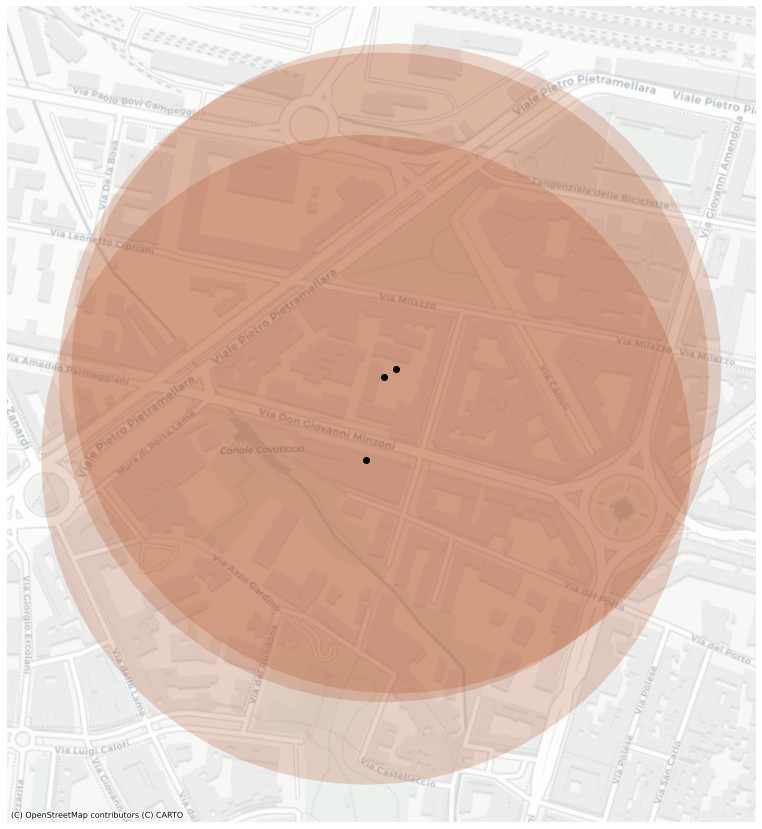

In [ ]:
fig, ax = plt.subplots(1, figsize=(20, 15))

nearest.head(3).to_crs(epsg=32632).plot(ax=ax, alpha=.2, color="#a83c09")
ax.axis("off")

plt.scatter(x=[nearest.head(3).centroid.x], y=[nearest.head(3).centroid.y], c="black")

cx.add_basemap(ax,crs=nearest.to_crs(epsg=32632).crs.to_string(),
               source=cx.providers.CartoDB.Positron)
fig.show()